# Machine Learning Essentials - Summer Semester 2024 Exercise 03
## Team-Member
### 1. Sushmitha Chandrakumar - 4732591
### 2. Colin Fredynand - 4730221

# **1 Introduction**

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████████████████████████████████████████████████████████████████████████████████████████████| 9912422/9912422 [00:06<00:00, 1474114.02it/s]


Extracting ./MNIST/raw/train-images-idx3-ubyte.gz to ./MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|███████████████████████████████████████████████████████████████████████████████████████████████████████| 28881/28881 [00:00<00:00, 262178.61it/s]


Extracting ./MNIST/raw/train-labels-idx1-ubyte.gz to ./MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████████████████████████████████████████████████████████████████████████████████████████████| 1648877/1648877 [00:00<00:00, 1821967.43it/s]


Extracting ./MNIST/raw/t10k-images-idx3-ubyte.gz to ./MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|████████████████████████████████████████████████████████████████████████████████████████████████████████| 4542/4542 [00:00<00:00, 1002870.54it/s]

Extracting ./MNIST/raw/t10k-labels-idx1-ubyte.gz to ./MNIST/raw



Epoch: 0
Mean Train Loss: 3.96e-01
Mean Test Loss:  2.07e-01
Epoch: 10
Mean Train Loss: 1.50e-01
Mean Test Loss:  2.95e-01
Epoch: 20
Mean Train Loss: 9.83e-02
Mean Test Loss:  4.92e-01
Epoch: 30
Mean Train Loss: 7.60e-02
Mean Test Loss:  4.79e-01
Epoch: 40
Mean Train Loss: 5.69e-02
Mean Test Loss:  7.24e-01
Epoch: 50
Mean Train Loss: 3.53e-02
Mean Test Loss:  6.94e-01
Epoch: 60
Mean Train Loss: 3.25e-02
Mean Test Loss:  8.52e-01
Epoch: 70
Mean Train Loss: 1.93e-02
Mean Test Loss:  8.17e-01
Epoch: 80
Mean Train Loss: 1.19e-02
Mean Test Loss:  7.80e-01
Epoch: 90
Mean Train Loss: 2.15e-02
Mean Test Loss:  8.05e-01
Epoch: 100
Mean Train Loss: 1.25e-02
Mean Test Loss:  9.97e-01


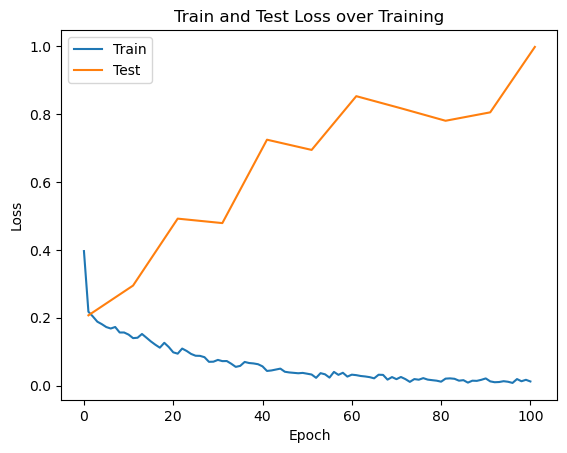

In [1]:

import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.optim as optim
from torch.utils.data import DataLoader

import torchvision.datasets as datasets
import torchvision.transforms as transforms

from torch.nn.functional import conv2d, max_pool2d, cross_entropy

plt.rc("figure", dpi=100)

batch_size = 100

# transform images into normalized tensors
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=(0.5,), std=(0.5,))
])

train_dataset = datasets.MNIST(
    "./",
    download=True,
    train=True,
    transform=transform,
)

test_dataset = datasets.MNIST(
    "./",
    download=True,
    train=False,
    transform=transform,
)

train_dataloader = DataLoader(
    dataset=train_dataset,
    batch_size=batch_size,
    shuffle=True,
    num_workers=1,
    pin_memory=True,
)

test_dataloader = DataLoader(
    dataset=test_dataset,
    batch_size=batch_size,
    shuffle=False,
    num_workers=1,
    pin_memory=True,
)

def init_weights(shape):
    # Kaiming He initialization (a good initialization is important)
    # https://arxiv.org/abs/1502.01852
    std = np.sqrt(2. / shape[0])
    w = torch.randn(size=shape) * std
    w.requires_grad = True
    return w


def rectify(x):
    # Rectified Linear Unit (ReLU)
    return torch.max(torch.zeros_like(x), x)


class RMSprop(optim.Optimizer):
    """
    This is a reduced version of the PyTorch internal RMSprop optimizer
    It serves here as an example
    """
    def __init__(self, params, lr=1e-3, alpha=0.5, eps=1e-8):
        defaults = dict(lr=lr, alpha=alpha, eps=eps)
        super(RMSprop, self).__init__(params, defaults)

    def step(self):
        for group in self.param_groups:
            for p in group['params']:
                grad = p.grad.data
                state = self.state[p]

                # state initialization
                if len(state) == 0:
                    state['square_avg'] = torch.zeros_like(p.data)

                square_avg = state['square_avg']
                alpha = group['alpha']

                # update running averages
                square_avg.mul_(alpha).addcmul_(grad, grad, value=1 - alpha)
                avg = square_avg.sqrt().add_(group['eps'])

                # gradient update
                p.data.addcdiv_(grad, avg, value=-group['lr'])


# define the neural network
def model(x, w_h, w_h2, w_o):
    h = rectify(x @ w_h)
    h2 = rectify(h @ w_h2)
    pre_softmax = h2 @ w_o
    return pre_softmax


# initialize weights

# input shape is (B, 784)
w_h = init_weights((784, 625))
# hidden layer with 625 neurons
w_h2 = init_weights((625, 625))
# hidden layer with 625 neurons
w_o = init_weights((625, 10))
# output shape is (B, 10)

optimizer = RMSprop(params=[w_h, w_h2, w_o])


n_epochs = 100

train_loss = []
test_loss = []

# put this into a training loop over 100 epochs
for epoch in range(n_epochs + 1):
    train_loss_this_epoch = []
    for idx, batch in enumerate(train_dataloader):
        x, y = batch

        # our model requires flattened input
        x = x.reshape(batch_size, 784)
        # feed input through model
        noise_py_x = model(x, w_h, w_h2, w_o)

        # reset the gradient
        optimizer.zero_grad()

        # the cross-entropy loss function already contains the softmax
        loss = cross_entropy(noise_py_x, y, reduction="mean")

        train_loss_this_epoch.append(float(loss))

        # compute the gradient
        loss.backward()
        # update weights
        optimizer.step()

    train_loss.append(np.mean(train_loss_this_epoch))

    # test periodically
    if epoch % 10 == 0:
        print(f"Epoch: {epoch}")
        print(f"Mean Train Loss: {train_loss[-1]:.2e}")
        test_loss_this_epoch = []

        # no need to compute gradients for validation
        with torch.no_grad():
            for idx, batch in enumerate(test_dataloader):
                x, y = batch
                x = x.reshape(batch_size, 784)
                noise_py_x = model(x, w_h, w_h2, w_o)

                loss = cross_entropy(noise_py_x, y, reduction="mean")
                test_loss_this_epoch.append(float(loss))

        test_loss.append(np.mean(test_loss_this_epoch))

        print(f"Mean Test Loss:  {test_loss[-1]:.2e}")

plt.plot(np.arange(n_epochs + 1), train_loss, label="Train")
plt.plot(np.arange(1, n_epochs + 2, 10), test_loss, label="Test")
plt.title("Train and Test Loss over Training")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()


# **2 Dropout**

In [5]:

def dropout(X, p_drop=0.5):
    if 0 < p_drop < 1:
        mask = torch.bernoulli(torch.full_like(X, 1 - p_drop))
        X = X * mask / (1 - p_drop)
    return X

def dropout_model(X, w_h, w_h2, w_o, p_drop_input, p_drop_hidden):
    X = dropout(X, p_drop_input)
    h = rectify(X @ w_h)
    h = dropout(h, p_drop_hidden)
    h2 = rectify(h @ w_h2)
    h2 = dropout(h2, p_drop_hidden)
    pre_softmax = h2 @ w_o
    return pre_softmax


# **Explanation of Dropout and Overfitting Reduction**
Dropout works by randomly "dropping out" a fraction of the neurons during training. This process forces the neural network to learn redundant representations of the data, thus preventing overfitting. The network cannot rely on the presence of any specific neurons, so it must be robust enough to perform well with various subsets of neurons. This randomness during training promotes generalization, making the network perform better on unseen data.
### **Training with Dropout**
Here is the updated training loop using the dropout_model function:

Epoch: 0
Mean Train Loss with Dropout: 2.93e+00
Mean Test Loss with Dropout: 2.50e-01
Epoch: 10
Mean Train Loss with Dropout: 8.51e-01
Mean Test Loss with Dropout: 2.04e-01
Epoch: 20
Mean Train Loss with Dropout: 9.86e-01
Mean Test Loss with Dropout: 2.56e-01
Epoch: 30
Mean Train Loss with Dropout: 1.06e+00
Mean Test Loss with Dropout: 3.14e-01
Epoch: 40
Mean Train Loss with Dropout: 1.12e+00
Mean Test Loss with Dropout: 3.81e-01
Epoch: 50
Mean Train Loss with Dropout: 1.14e+00
Mean Test Loss with Dropout: 3.83e-01
Epoch: 60
Mean Train Loss with Dropout: 1.28e+00
Mean Test Loss with Dropout: 4.33e-01
Epoch: 70
Mean Train Loss with Dropout: 1.33e+00
Mean Test Loss with Dropout: 4.17e-01
Epoch: 80
Mean Train Loss with Dropout: 1.33e+00
Mean Test Loss with Dropout: 5.24e-01
Epoch: 90
Mean Train Loss with Dropout: 1.35e+00
Mean Test Loss with Dropout: 4.71e-01
Epoch: 100
Mean Train Loss with Dropout: 1.48e+00
Mean Test Loss with Dropout: 5.09e-01


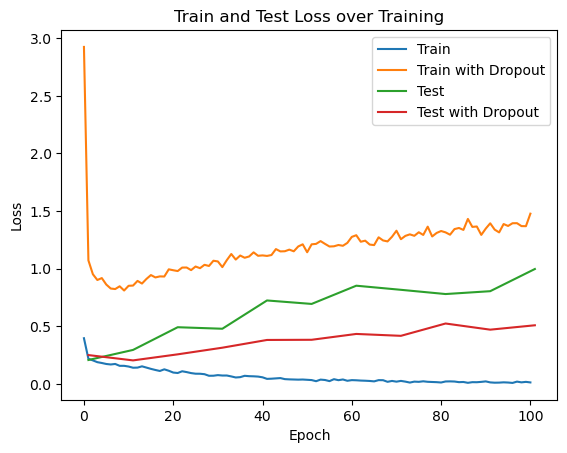

In [8]:
p_drop_input = 0.2
p_drop_hidden = 0.5

train_loss_dropout = []
test_loss_dropout = []

for epoch in range(n_epochs + 1):
    train_loss_this_epoch = []
    for idx, batch in enumerate(train_dataloader):
        x, y = batch
        x = x.reshape(batch_size, 784)
        noise_py_x = dropout_model(x, w_h, w_h2, w_o, p_drop_input, p_drop_hidden)

        optimizer.zero_grad()
        loss = cross_entropy(noise_py_x, y, reduction="mean")
        train_loss_this_epoch.append(float(loss))

        loss.backward()
        optimizer.step()

    train_loss_dropout.append(np.mean(train_loss_this_epoch))

    if epoch % 10 == 0:
        print(f"Epoch: {epoch}")
        print(f"Mean Train Loss with Dropout: {train_loss_dropout[-1]:.2e}")
        test_loss_this_epoch = []

        with torch.no_grad():
            for idx, batch in enumerate(test_dataloader):
                x, y = batch
                x = x.reshape(batch_size, 784)
                noise_py_x = dropout_model(x, w_h, w_h2, w_o, 0, 0)  # Disable dropout during evaluation

                loss = cross_entropy(noise_py_x, y, reduction="mean")
                test_loss_this_epoch.append(float(loss))

        test_loss_dropout.append(np.mean(test_loss_this_epoch))
        print(f"Mean Test Loss with Dropout: {test_loss_dropout[-1]:.2e}")

plt.plot(np.arange(n_epochs + 1), train_loss, label="Train")
plt.plot(np.arange(n_epochs + 1), train_loss_dropout, label="Train with Dropout")
plt.plot(np.arange(1, n_epochs + 2, 10), test_loss, label="Test")
plt.plot(np.arange(1, n_epochs + 2, 10), test_loss_dropout, label="Test with Dropout")
plt.title("Train and Test Loss over Training")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.show()


# **3 Parametric ReLU Implementation and Integration**
Parametric ReLU (PReLU) is an extension of the ReLU activation function that allows for a learnable parameter
𝛼
α (referred to as a here). It adapts the slope of the negative part of the input, making the function more flexible.

### **PReLU Function Definition**

In [39]:
import torch.nn as nn

def PRelu(X, a):
    return torch.max(X, torch.zeros_like(X)) + a * torch.min(X, torch.zeros_like(X))

### **Updated Model with PReLU**

In [42]:
def init_weights(shape):
    return nn.Parameter(torch.randn(shape) * 0.01)

# Define the neural network using PReLU
def model_PRelu(x, w_h, w_h2, w_o, a):
    h = PRelu(x @ w_h, a)
    h2 = PRelu(h @ w_h2, a)
    pre_softmax = h2 @ w_o
    return pre_softmax

# Initialize weights
w_h = init_weights((784, 625))
w_h2 = init_weights((625, 625))
w_o = init_weights((625, 10))
a = nn.Parameter(torch.randn(1, 1) * 0.01)  # Learnable parameter for PReLU

# Initialize optimizer
optimizer = optim.RMSprop([w_h, w_h2, w_o, a], lr=0.001)

### **Training with PReLU**

Epoch: 0
Mean Train Loss: 2.31e+00
Mean Test Loss: 2.30e+00
Epoch: 10
Mean Train Loss: 1.15e-01
Mean Test Loss: 6.66e+00
Epoch: 20
Mean Train Loss: 1.15e-05
Mean Test Loss: 9.15e+00
Epoch: 30
Mean Train Loss: 7.73e-08
Mean Test Loss: 1.06e+01
Epoch: 40
Mean Train Loss: 1.82e-03
Mean Test Loss: 1.14e+01
Epoch: 50
Mean Train Loss: 1.69e-06
Mean Test Loss: 1.14e+01
Epoch: 60
Mean Train Loss: 2.78e-08
Mean Test Loss: 1.19e+01
Epoch: 70
Mean Train Loss: 1.14e-03
Mean Test Loss: 1.34e+01
Epoch: 80
Mean Train Loss: 1.31e-06
Mean Test Loss: 1.33e+01
Epoch: 90
Mean Train Loss: 2.55e-08
Mean Test Loss: 1.35e+01
Epoch: 100
Mean Train Loss: 2.93e+00
Mean Test Loss: 1.51e+01


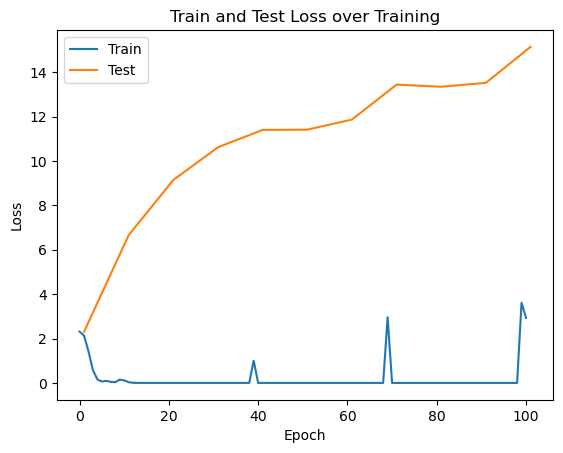

In [45]:
# Training and evaluation parameters
n_epochs = 100
batch_size = 64

# Placeholder data loaders (replace with actual data loaders)
train_dataloader = [(torch.randn(batch_size, 1, 28, 28), torch.randint(0, 10, (batch_size,))) for _ in range(100)]
test_dataloader = [(torch.randn(batch_size, 1, 28, 28), torch.randint(0, 10, (batch_size,))) for _ in range(20)]

# Loss function
criterion = nn.CrossEntropyLoss()

train_loss = []
test_loss = []

# Training loop
for epoch in range(n_epochs + 1):
    train_loss_this_epoch = []
    for idx, batch in enumerate(train_dataloader):
        x, y = batch

        # Flatten input
        x = x.view(batch_size, 784)
        # Feed input through model
        noise_py_x = model_PRelu(x, w_h, w_h2, w_o, a)

        # Reset the gradient
        optimizer.zero_grad()

        # Compute loss
        loss = criterion(noise_py_x, y)
        train_loss_this_epoch.append(loss.item())

        # Backpropagation and weight update
        loss.backward()
        optimizer.step()

    train_loss.append(np.mean(train_loss_this_epoch))

    # Test periodically
    if epoch % 10 == 0:
        print(f"Epoch: {epoch}")
        print(f"Mean Train Loss: {train_loss[-1]:.2e}")
        test_loss_this_epoch = []

        # Evaluation without gradient computation
        with torch.no_grad():
            for idx, batch in enumerate(test_dataloader):
                x, y = batch
                x = x.view(batch_size, 784)
                noise_py_x = model_PRelu(x, w_h, w_h2, w_o, a)

                loss = criterion(noise_py_x, y)
                test_loss_this_epoch.append(loss.item())

        test_loss.append(np.mean(test_loss_this_epoch))
        print(f"Mean Test Loss: {test_loss[-1]:.2e}")

# Plotting the train and test loss over epochs
plt.plot(np.arange(n_epochs + 1), train_loss, label="Train")
plt.plot(np.arange(1, n_epochs + 2, 10), test_loss, label="Test")
plt.title("Train and Test Loss over Training")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.show()


### **Comparison with Previous Models**
Comparing the results with the previous models (standard model and dropout model) involves examining the train and test losses for each model. PReLU should ideally provide more flexibility in the activation function, potentially leading to better performance, especially if the data benefits from the adaptive nature of PReLU.

####**Standard Model**:
Baseline model using ReLU.
####**Dropout Model**:
 Adds dropout to prevent overfitting.
####**PReLU Model:**
Adds the adaptive PReLU activation, potentially improving performance by allowing a learnable negative slope.
### **Explanation of PReLU**
PReLU introduces learnable parameters that adapt the slope for negative input values. This adaptation can capture more nuanced patterns in the data, offering the model more flexibility compared to the standard ReLU. By optimizing these parameters during training, the network can better adjust to the data characteristics, potentially leading to improved performance and faster convergence.

# **4 Convolutional layers**

In [63]:
batch_size = 64
num_classes = 10
learning_rate = 0.001
num_epochs = 10

# Device will determine whether to run the training on GPU or CPU.
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
#####################################################################

# input_layer = torch.randn(batch_size, 1, 32, 32)
# weightvector = nn.Parameter(torch.randn(20, 1, 5, 5))

# previous_layer = input_layer

convolutional_layer = rectify(conv2d(previous_layer, weightvector))
# reduces (2 ,2) window to 1 pixel
subsampling_layer = (max_pool2d(convolutional_layer, (2 , 2)))
out_layer = dropout (subsampling_layer, p_drop_input)
######################################################################

#Loading the dataset and preprocessing
train_dataset = datasets.MNIST(root = './data',
                                           train = True,
                                           transform = transforms.Compose([
                                                  transforms.Resize((32,32)),
                                                  transforms.ToTensor(),
                                                  transforms.Normalize(mean = (0.1307,), std = (0.3081,))]),
                                           download = True)


test_dataset = datasets.MNIST(root = './data',
                                          train = False,
                                          transform = transforms.Compose([
                                                  transforms.Resize((32,32)),
                                                  transforms.ToTensor(),
                                                  transforms.Normalize(mean = (0.1325,), std = (0.3105,))]),
                                          download=True)


train_loader = torch.utils.data.DataLoader(dataset = train_dataset,
                                           batch_size = batch_size,
                                           shuffle = True)


test_loader = torch.utils.data.DataLoader(dataset = test_dataset,
                                           batch_size = batch_size,
                                           shuffle = True)

### 4.1. Create a Convolutional network

In [78]:
#Defining the convolutional neural network
class LeNet5(nn.Module):
    def __init__(self, num_classes):
        super(LeNet5, self).__init__()
        self.layer1 = nn.Sequential(
            nn.Conv2d(1, 6, kernel_size=5, stride=1, padding=0),
            nn.BatchNorm2d(6),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size = 2, stride = 2))
        self.layer2 = nn.Sequential(
            nn.Conv2d(6, 16, kernel_size=5, stride=1, padding=0),
            nn.BatchNorm2d(16),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size = 2, stride = 2))
        self.fc = nn.Linear(400, 120)
        self.relu = nn.ReLU()
        self.fc1 = nn.Linear(120, 84)
        self.relu1 = nn.ReLU()
        self.fc2 = nn.Linear(84, num_classes)

    def forward(self, x):
        out = self.layer1(x)
        out = self.layer2(out)
        out = out.reshape(out.size(0), -1)
        out = self.fc(out)
        out = self.relu(out)
        out = self.fc1(out)
        out = self.relu1(out)
        out = self.fc2(out)
        return out

### 4.2. Application of Convolutional network

Epoch [1/10], Step [400/938], Loss: 0.0895
Epoch [1/10], Step [800/938], Loss: 0.0299
Epoch [2/10], Step [400/938], Loss: 0.0392
Epoch [2/10], Step [800/938], Loss: 0.0154
Epoch [3/10], Step [400/938], Loss: 0.0121
Epoch [3/10], Step [800/938], Loss: 0.0027
Epoch [4/10], Step [400/938], Loss: 0.0065
Epoch [4/10], Step [800/938], Loss: 0.0423
Epoch [5/10], Step [400/938], Loss: 0.0015
Epoch [5/10], Step [800/938], Loss: 0.0032
Epoch [6/10], Step [400/938], Loss: 0.0025
Epoch [6/10], Step [800/938], Loss: 0.0042
Epoch [7/10], Step [400/938], Loss: 0.0585
Epoch [7/10], Step [800/938], Loss: 0.0021
Epoch [8/10], Step [400/938], Loss: 0.0022
Epoch [8/10], Step [800/938], Loss: 0.0222
Epoch [9/10], Step [400/938], Loss: 0.0207
Epoch [9/10], Step [800/938], Loss: 0.0029
Epoch [10/10], Step [400/938], Loss: 0.0066
Epoch [10/10], Step [800/938], Loss: 0.0009


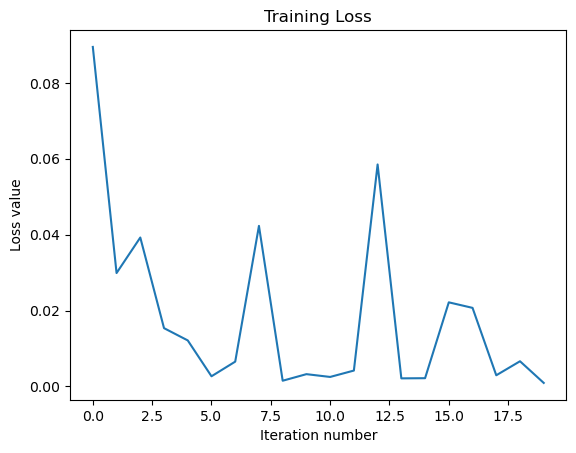

In [89]:
# Hyperparameters setup
model = LeNet5(num_classes).to(device)

#Setting the loss function
cost = nn.CrossEntropyLoss()

#Setting the optimizer with the model parameters and learning rate
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

#this is defined to print how many steps are remaining when training
total_step = len(train_loader)
######################################################################

loss_values = []

total_step = len(train_loader)
for epoch in range(num_epochs):
    for i, (images, labels) in enumerate(train_loader):
        images = images.to(device)
        labels = labels.to(device)

        #Forward pass
        outputs = model(images)
        loss = cost(outputs, labels)

        # Backward and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if (i+1) % 400 == 0:
            print ('Epoch [{}/{}], Step [{}/{}], Loss: {:.4f}'
        		           .format(epoch+1, num_epochs, i+1, total_step, loss.item()))
            loss_values.append(loss.item())
            
plt.plot(loss_values)
plt.xlabel('Iteration number')
plt.ylabel('Loss value')
plt.title('Training Loss')
plt.show()